# Датасет Melbourne Housing Snapshot
https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot?resource=download

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [4]:
data = pd.read_csv('/kaggle/input/melb-data/melb_data.csv', sep=",")

In [5]:
data.shape

(13580, 21)

In [6]:
data.dtypes

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object

In [7]:
data.isnull().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [8]:
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


## Обработка пропусков категориальных признаков

In [9]:
total_count = data.shape[0]

cat_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка CouncilArea. Тип данных object. Количество пустых значений 1369, 10.08%.


In [10]:
data['CouncilArea'].describe()

count        12211
unique          33
top       Moreland
freq          1163
Name: CouncilArea, dtype: object

In [11]:
data['CouncilArea'].unique()

array(['Yarra', 'Moonee Valley', 'Port Phillip', 'Darebin', 'Hobsons Bay',
       'Stonnington', 'Boroondara', 'Monash', 'Glen Eira', 'Whitehorse',
       'Maribyrnong', 'Bayside', 'Moreland', 'Manningham', 'Banyule',
       'Melbourne', 'Kingston', 'Brimbank', 'Hume', nan, 'Knox',
       'Maroondah', 'Casey', 'Melton', 'Greater Dandenong', 'Nillumbik',
       'Whittlesea', 'Frankston', 'Macedon Ranges', 'Yarra Ranges',
       'Wyndham', 'Cardinia', 'Unavailable', 'Moorabool'], dtype=object)

In [12]:
# Провериим корреляцию региона и цены
# Для этого закодируем колонку 'CouncilArea' в зависимости от ее средней цены
df_ca_and_target = data[['Price', 'CouncilArea']].copy()
df_ca_and_target.dropna(subset=['CouncilArea'], inplace=True)

encoder_map = {}
for index, row in df_ca_and_target.groupby(by='CouncilArea').mean().sort_values(by=['Price']).reset_index().iterrows():
    encoder_map[row['CouncilArea']] = index
    # print(index, row)

le = LabelEncoder()
df_ca_and_target['CouncilArea'] = df_ca_and_target['CouncilArea'].map(encoder_map)
df_ca_and_target.corr()

,Price,CouncilArea
Price,1.000000,0.423142
CouncilArea,0.423142,1.000000


In [13]:
# У нас есть небольшая корреляция между целевым признаком и ценой, поэтому просто удалим строки с пустыми значениями колонки 'CouncilArea'
data.dropna(subset=['CouncilArea'], inplace=True)

In [14]:
data['CouncilArea'].isnull().sum()

0

## Обработка пропусков числовых признаков

In [15]:
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка BuildingArea. Тип данных float64. Количество пустых значений 5765, 42.45%.
Колонка YearBuilt. Тип данных float64. Количество пустых значений 4763, 35.07%.


In [16]:
# Заполним пропуски в числовых признаков медианой, тк она меньше всего подвержена выбросам

def fill_missing_median(dataset, column):
    temp_data = dataset[[column]]
    
    imp_num = SimpleImputer(strategy='median')
    data_num_imp = imp_num.fit_transform(temp_data)


    return data_num_imp


In [17]:
cols_for_imp = ['BuildingArea', 'YearBuilt']
data[cols_for_imp].isnull().sum()

BuildingArea    5765
YearBuilt       4763
dtype: int64

In [18]:
for col in cols_for_imp:
    data[col] = fill_missing_median(data, col)
    print(f'After {col} imp:')
    print(data[cols_for_imp].isnull().sum())
    print()

After BuildingArea imp:
BuildingArea       0
YearBuilt       4763
dtype: int64

After YearBuilt imp:
BuildingArea    0
YearBuilt       0
dtype: int64



In [19]:
data.isnull().sum()

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64

## Преобразвание категориальных признаков в числовые

In [20]:
data.dtypes.loc[lambda x: x == 'object']

Suburb         object
Address        object
Type           object
Method         object
SellerG        object
Date           object
CouncilArea    object
Regionname     object
dtype: object

#### Date

In [21]:
data['Date'].unique()

array(['3/12/2016', '4/02/2016', '4/03/2017', '4/06/2016', '7/05/2016',
       '8/10/2016', '12/11/2016', '13/08/2016', '14/05/2016',
       '15/10/2016', '16/07/2016', '17/09/2016', '18/03/2017',
       '18/06/2016', '19/11/2016', '22/08/2016', '24/09/2016',
       '25/02/2017', '26/07/2016', '27/11/2016', '28/05/2016',
       '30/07/2016', '3/09/2016', '6/08/2016', '7/11/2016', '10/09/2016',
       '10/12/2016', '11/02/2017', '16/04/2016', '22/05/2016',
       '23/04/2016', '12/06/2016', '27/06/2016', '28/08/2016',
       '11/03/2017', '28/01/2016', '6/05/2017', '8/04/2017', '29/04/2017',
       '13/05/2017', '20/05/2017', '22/04/2017', '1/07/2017', '3/06/2017',
       '17/06/2017', '24/06/2017', '27/05/2017', '8/07/2017',
       '12/08/2017', '15/07/2017', '22/07/2017', '29/07/2017'],
      dtype=object)

In [22]:
# Разделим поле Date на day, month, year
date = pd.to_datetime(data['Date'], format='mixed')

data['Day'] = date.dt.day
data['Month'] = date.dt.month
data['Year'] = date.dt.year
data.drop(columns='Date', inplace=True)

data[['Day', 'Month', 'Year']]

,Day,Month,Year
0,12,3,2016
1,2,4,2016
2,3,4,2017
3,3,4,2017
4,6,4,2016
...,...,...,...
12208,29,7,2017
12209,29,7,2017
12210,29,7,2017
12211,29,7,2017


#### Adress

In [23]:
# Преобразуем улицу в адрес

data['Street'] = data['Address'].map(lambda addr: addr.split()[1])
data.drop(columns='Address', inplace=True)

data['Street']

0            Turner
1         Bloomburg
2           Charles
3        Federation
4              Park
            ...    
12208         Pasco
12209          Peel
12210      Saltlake
12211        Adeney
12212      Pentland
Name: Street, Length: 12211, dtype: object

In [24]:
data['Street'].unique().shape

(3721,)

#### Other

In [25]:
data.dtypes.loc[lambda x: x == 'object']

Suburb         object
Type           object
Method         object
SellerG        object
CouncilArea    object
Regionname     object
Street         object
dtype: object

In [26]:
obj_cols = list(data.dtypes.loc[lambda x: x == 'object'].index)
obj_cols

['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname', 'Street']

In [27]:
data_obj = data[obj_cols]

oe = OrdinalEncoder()
data_obj_enc = oe.fit_transform(data_obj)

In [28]:
data[obj_cols] = data_obj_enc
data[obj_cols]

,Suburb,Type,Method,SellerG,CouncilArea,Regionname,Street
0,0.0,0.0,1.0,22.0,31.0,2.0,3377.0
1,0.0,0.0,1.0,22.0,31.0,2.0,377.0
2,0.0,0.0,3.0,22.0,31.0,2.0,668.0
3,0.0,0.0,0.0,22.0,31.0,2.0,1246.0
4,0.0,0.0,4.0,146.0,31.0,2.0,2657.0
...,...,...,...,...,...,...,...
12208,299.0,0.0,1.0,100.0,10.0,6.0,2670.0
12209,301.0,2.0,0.0,245.0,26.0,5.0,2691.0
12210,302.0,0.0,1.0,207.0,29.0,2.0,2995.0
12211,307.0,0.0,3.0,245.0,16.0,6.0,24.0


In [29]:
data.describe()

,Suburb,Rooms,Type,Price,Method,SellerG,Distance,Postcode,Bedroom2,Bathroom,...,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Day,Month,Year,Street
count,12211.000000,12211.000000,12211.000000,1.221100e+04,12211.000000,12211.000000,12211.000000,12211.000000,12211.000000,12211.000000,...,12211.000000,12211.000000,12211.000000,12211.000000,12211.000000,12211.000000,12211.000000,12211.000000,12211.000000,12211.000000
mean,152.520514,2.894194,0.570715,1.063692e+06,1.404389,123.668741,9.764368,3103.110638,2.868397,1.517402,...,1966.709770,14.767668,-37.809054,144.993148,3.800917,7452.984358,16.297682,6.586520,2016.481124,1895.106953
std,89.000246,0.959341,0.854515,6.388613e+05,1.117471,73.079999,5.507993,87.359029,0.969456,0.688923,...,29.382804,9.834752,0.075242,0.098867,2.004398,4369.616618,8.212707,2.800277,0.499664,1083.324225
min,0.000000,1.000000,0.000000,8.500000e+04,0.000000,0.000000,0.000000,3000.000000,0.000000,0.000000,...,1196.000000,0.000000,-38.182550,144.431810,0.000000,249.000000,2.000000,1.000000,2016.000000,0.000000
25%,67.000000,2.000000,0.000000,6.400000e+05,1.000000,70.000000,5.900000,3044.000000,2.000000,1.000000,...,1960.000000,6.000000,-37.855600,144.929900,2.000000,4380.000000,9.000000,5.000000,2016.000000,962.000000
50%,153.000000,3.000000,0.000000,8.950000e+05,1.000000,128.000000,9.200000,3083.000000,3.000000,1.000000,...,1970.000000,16.000000,-37.802200,144.998580,5.000000,6567.000000,16.000000,6.000000,2016.000000,1909.000000
75%,229.000000,3.000000,1.000000,1.320000e+06,1.000000,183.000000,12.600000,3147.000000,3.000000,2.000000,...,1975.000000,23.000000,-37.757735,145.054200,5.000000,10331.000000,24.000000,8.000000,2017.000000,2821.000000
max,307.000000,10.000000,2.000000,9.000000e+06,4.000000,252.000000,47.400000,3977.000000,20.000000,8.000000,...,2018.000000,32.000000,-37.457090,145.526350,7.000000,21650.000000,30.000000,12.000000,2017.000000,3720.000000


In [30]:
data.dtypes.loc[lambda x: x == 'object'].size

0

## Масштабирование данных

#### До применения Z скеллинга

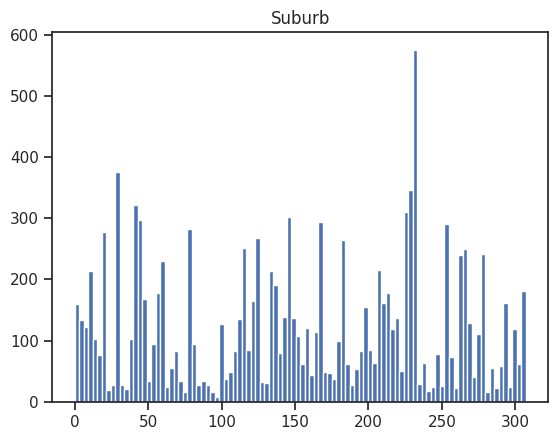

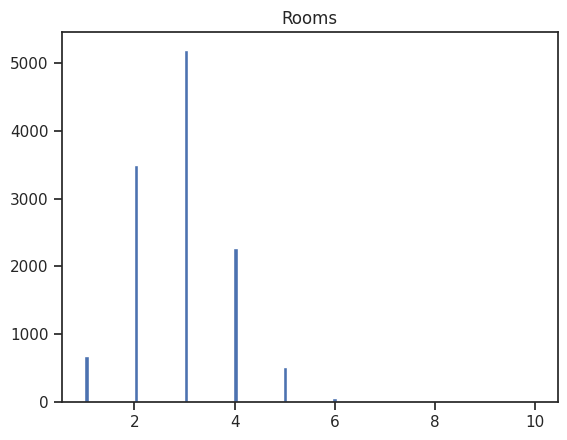

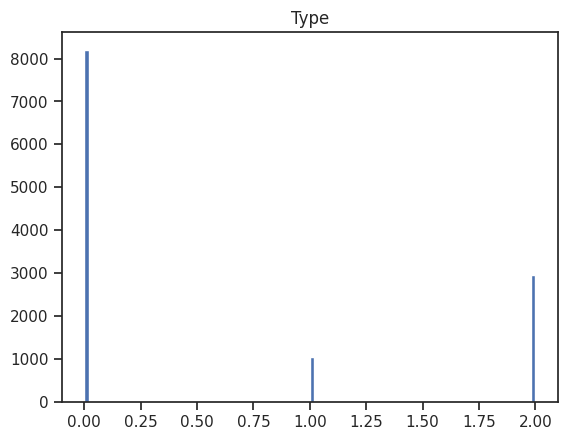

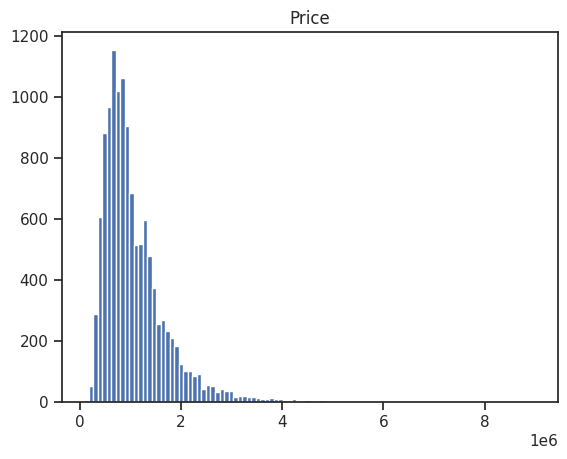

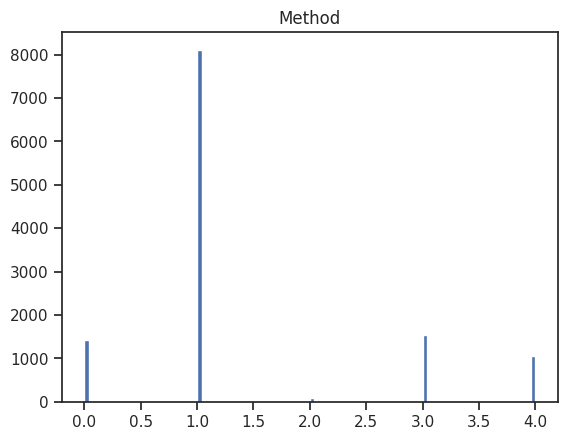

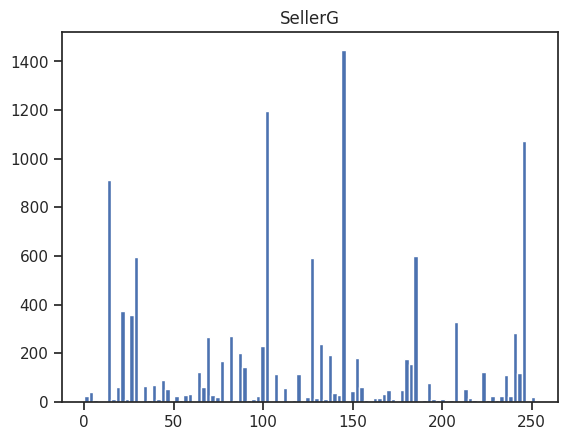

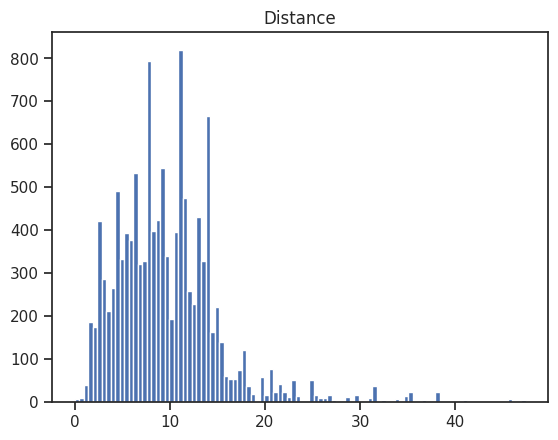

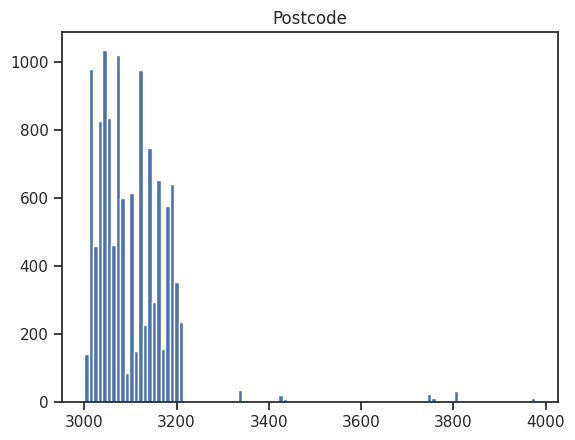

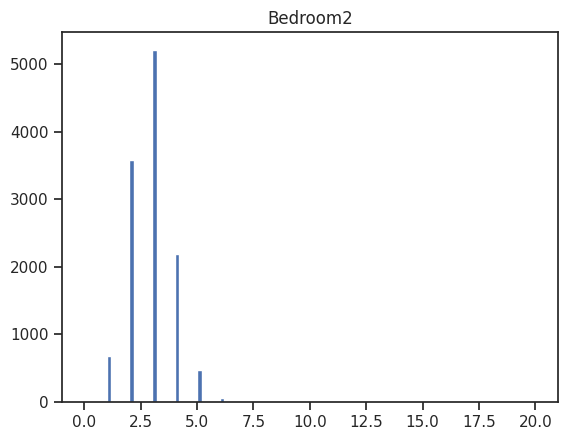

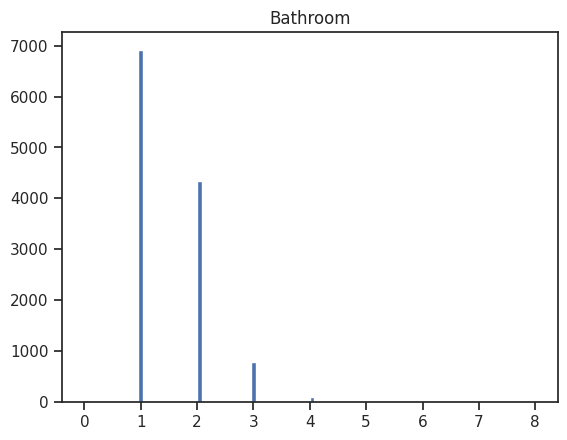

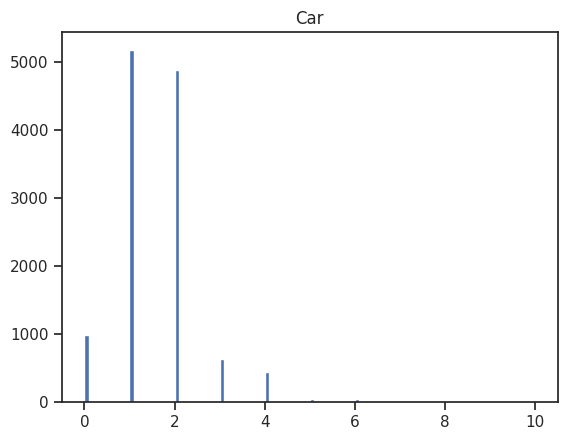

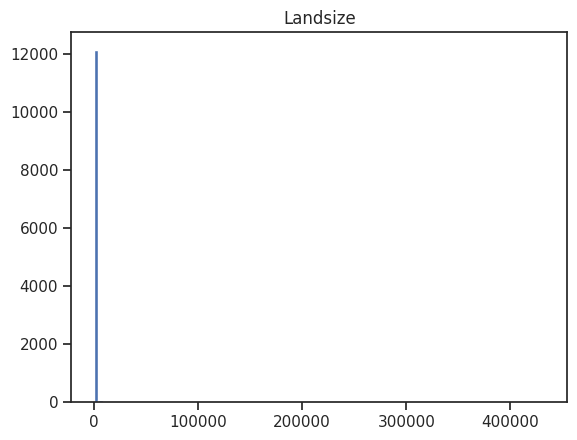

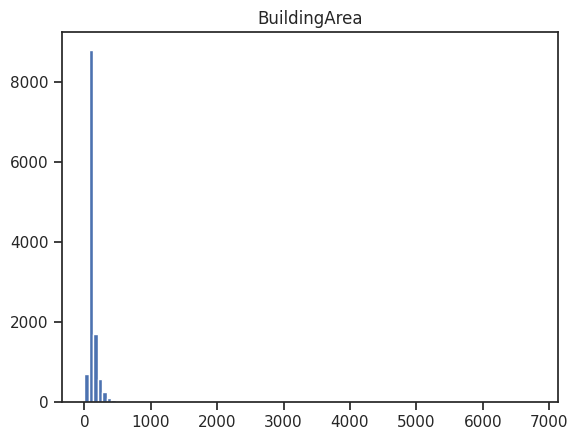

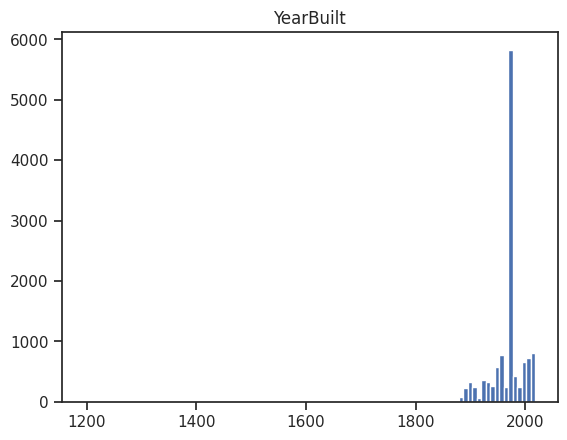

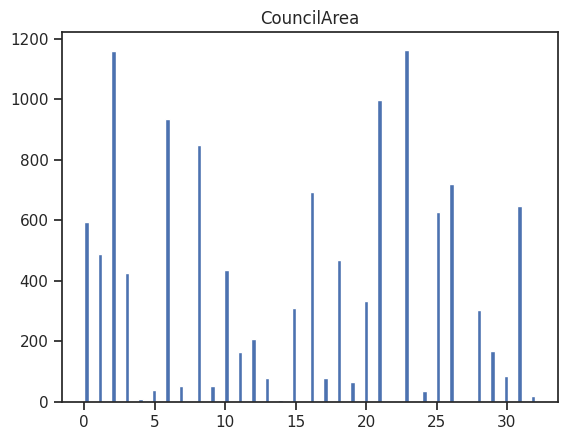

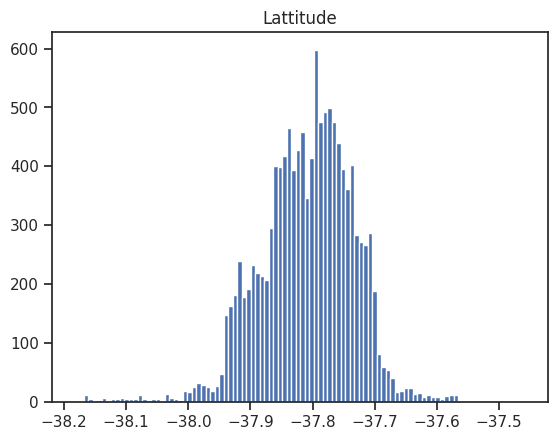

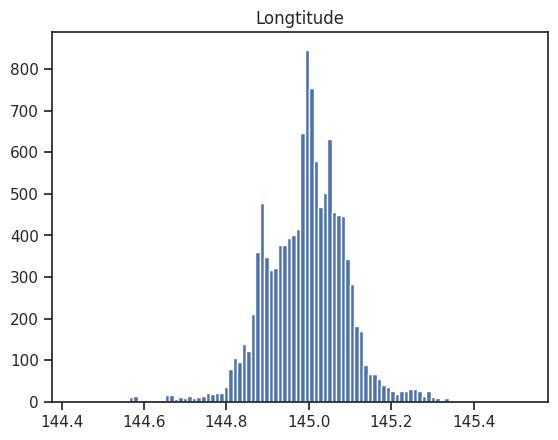

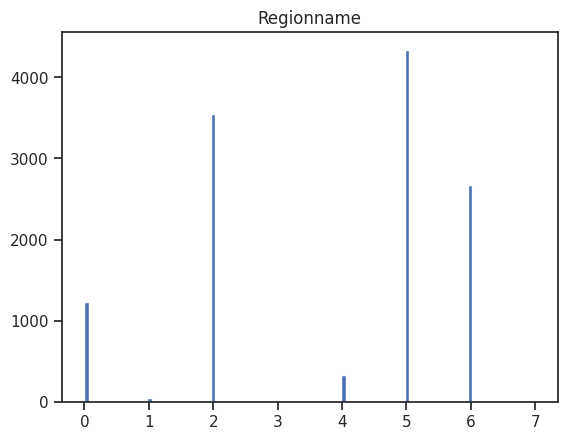

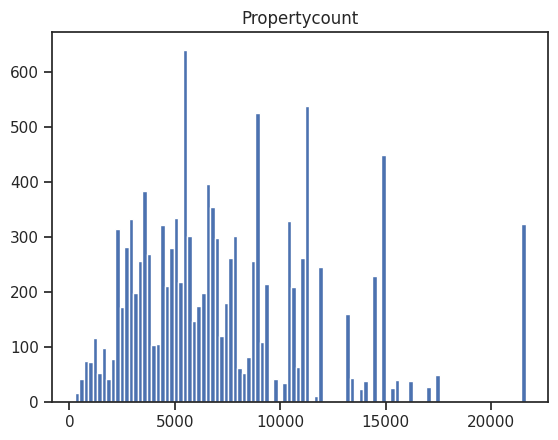

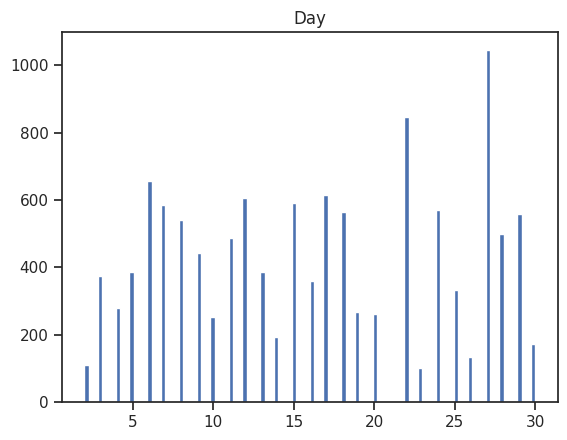

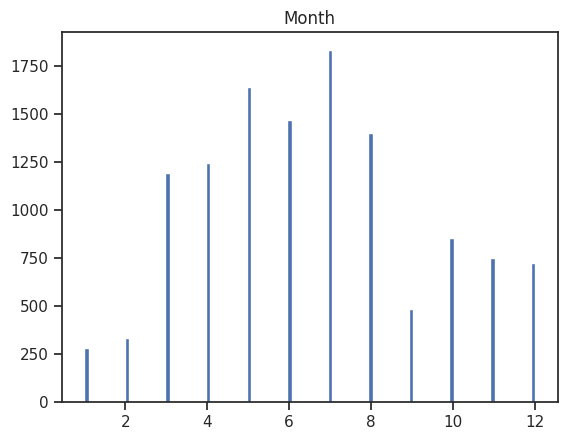

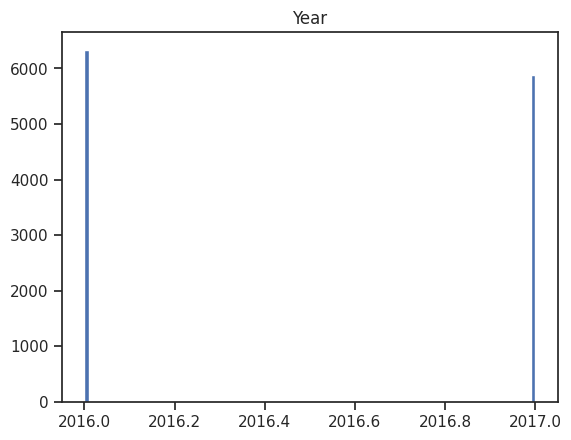

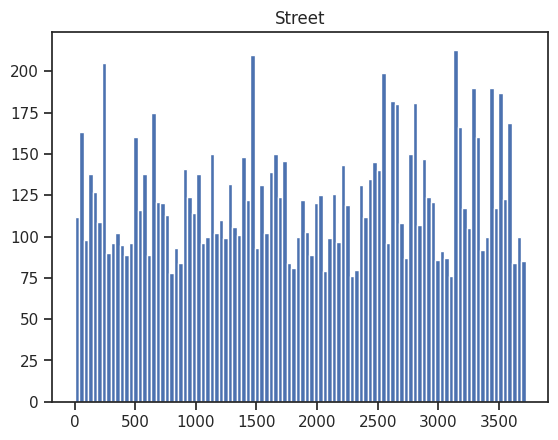

In [31]:
for col in data.columns:
    plt.hist(data[col], 100)
    plt.title(col)
    plt.show()

#### После

In [32]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

In [33]:
sc2 = StandardScaler()
sc2_data = sc2.fit_transform(data)

In [34]:
sc2_data = pd.DataFrame(sc2_data, columns=data.columns)

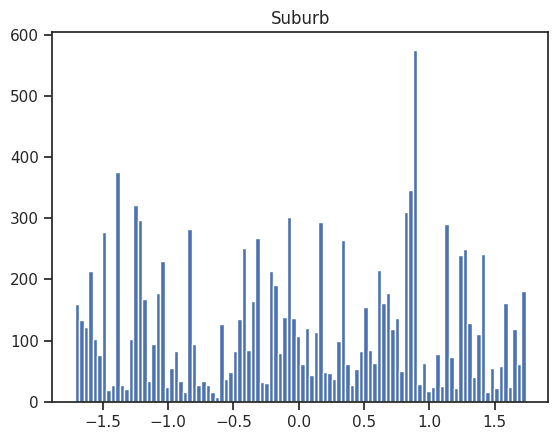

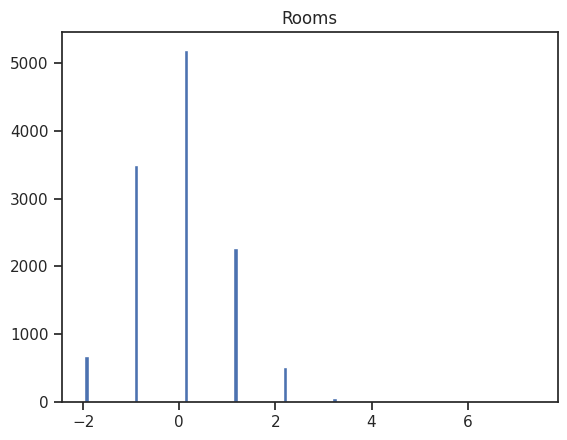

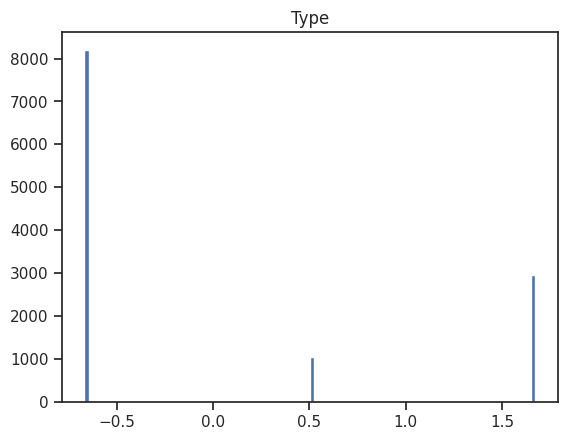

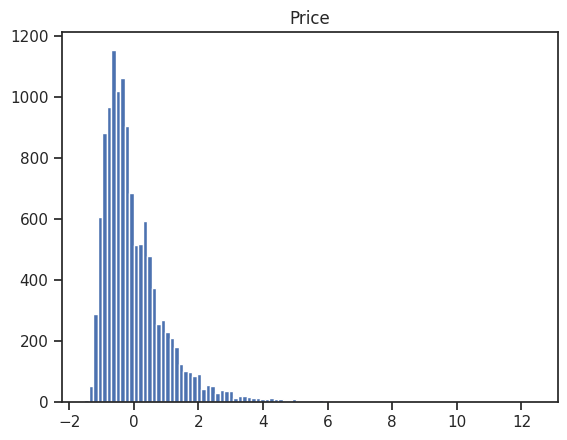

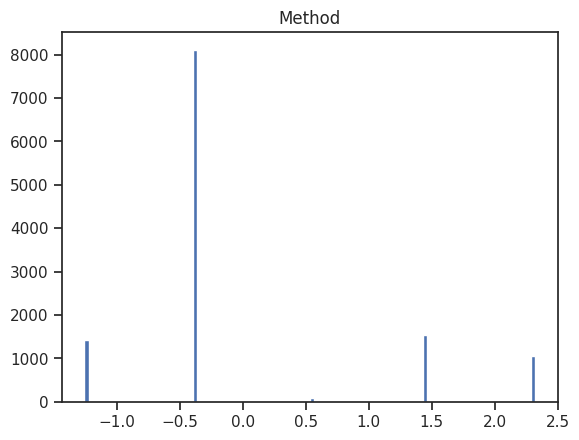

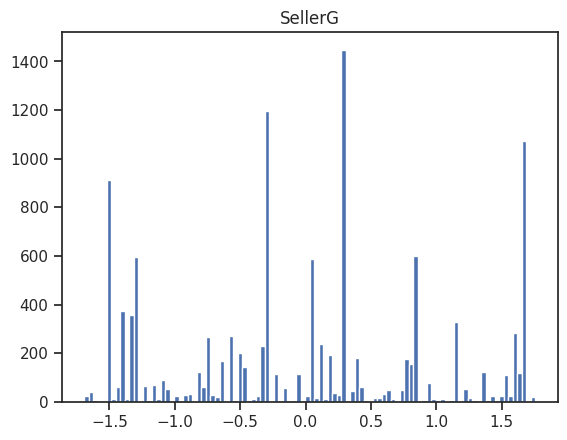

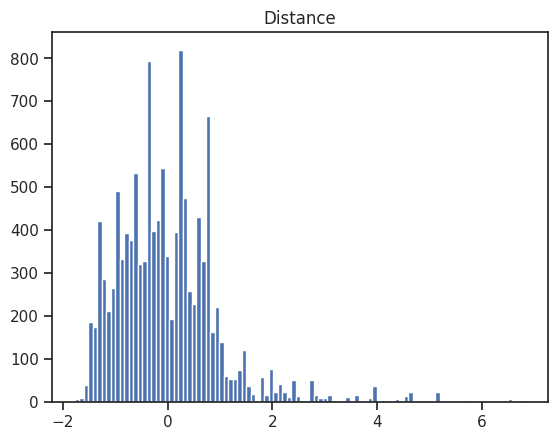

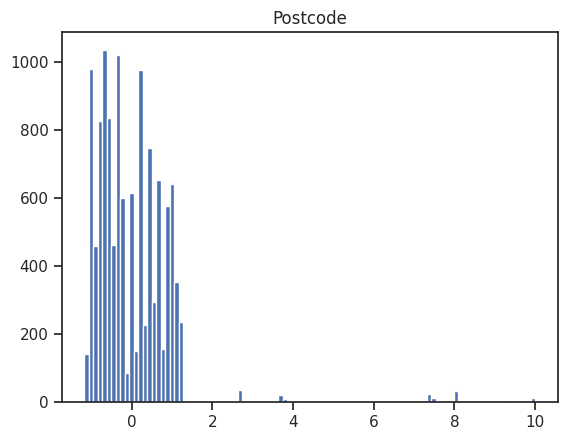

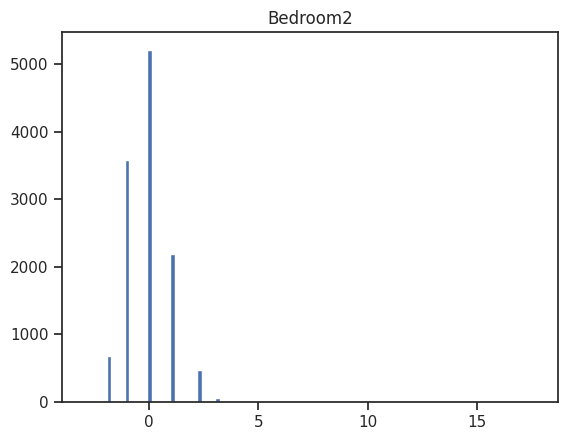

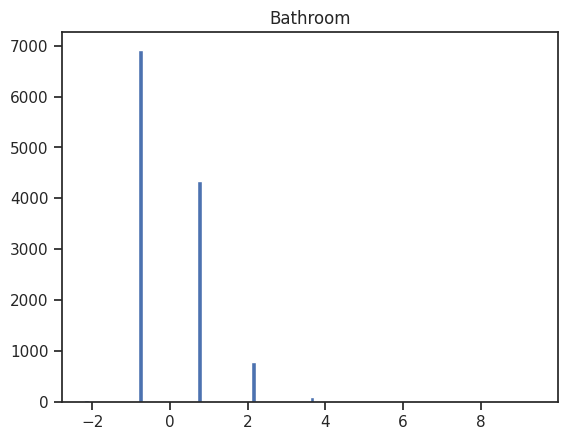

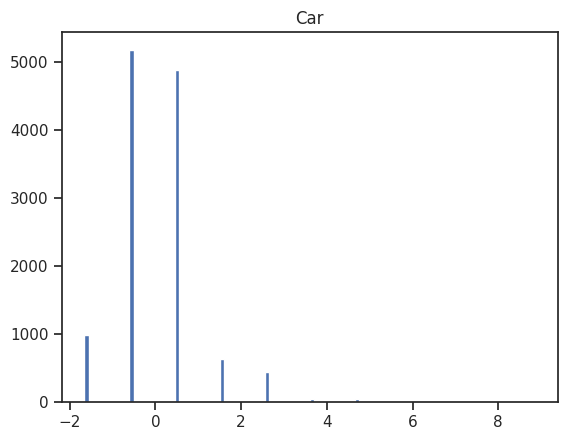

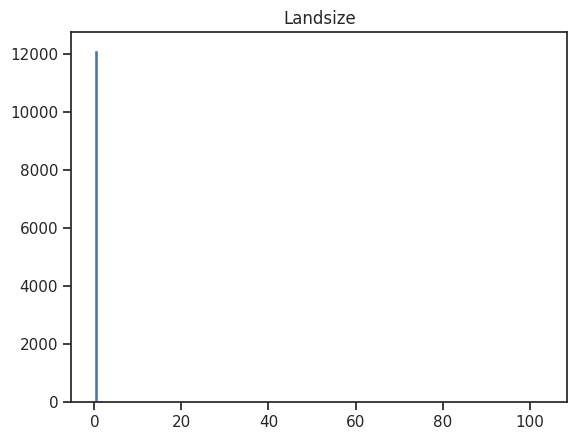

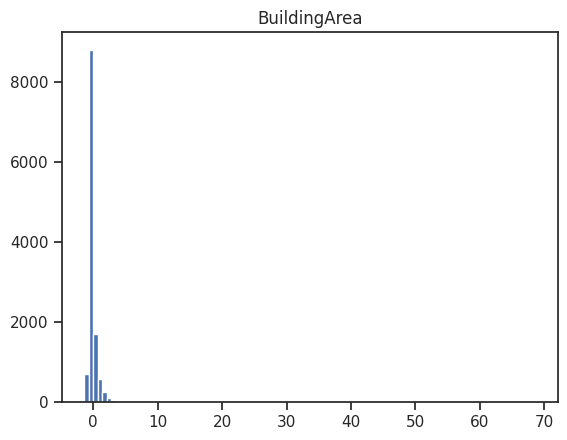

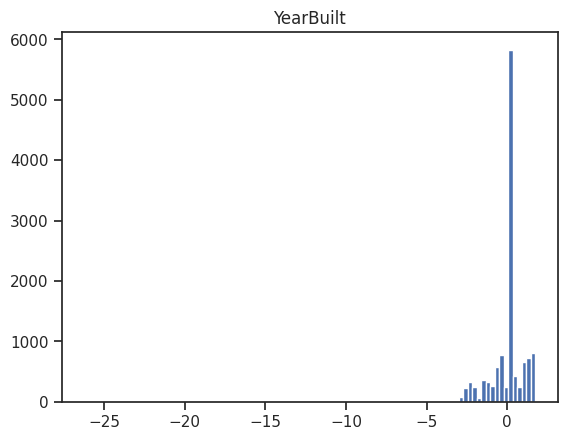

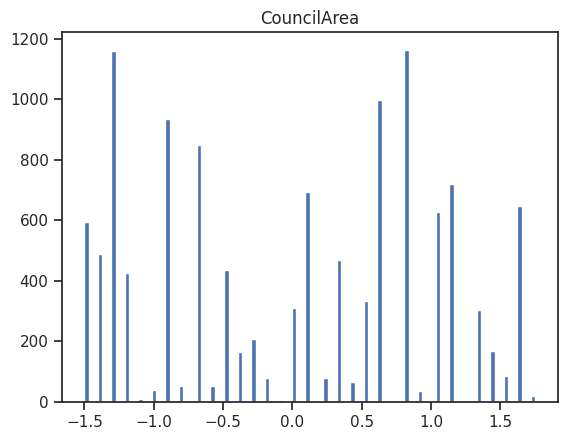

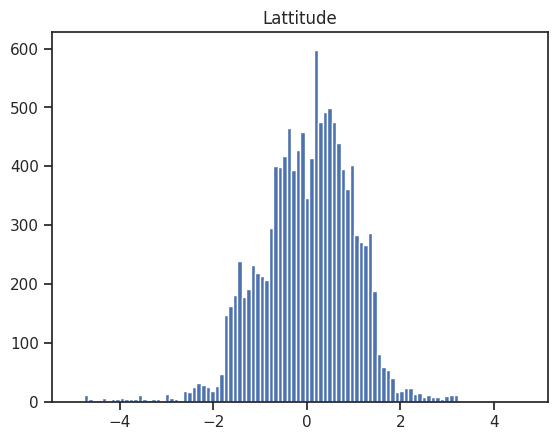

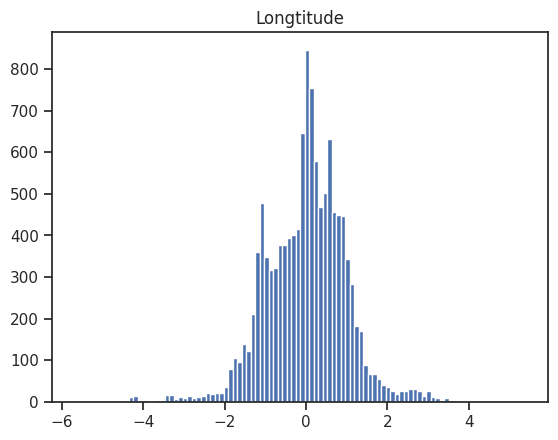

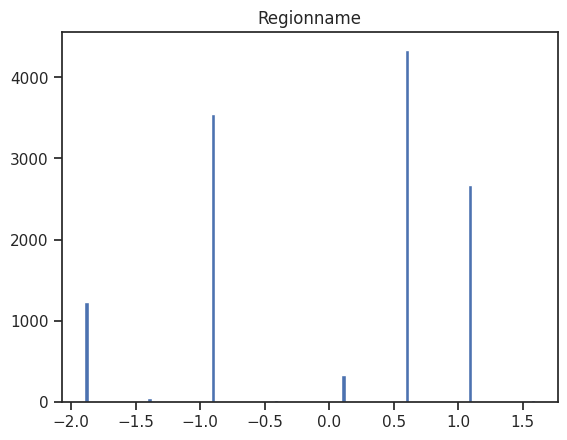

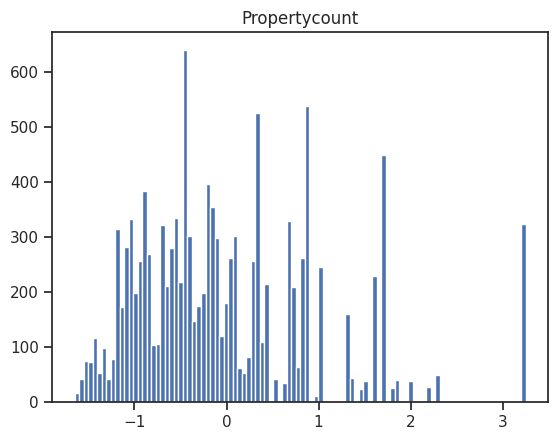

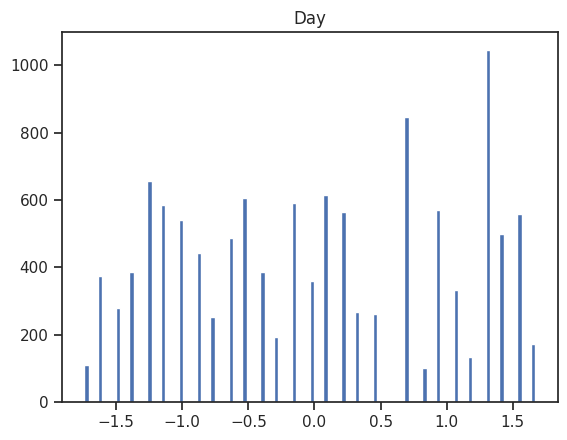

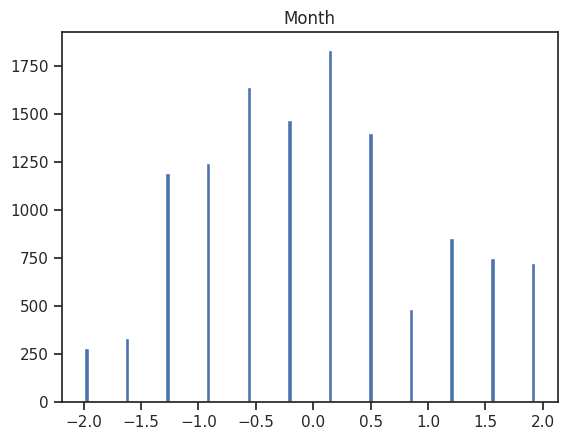

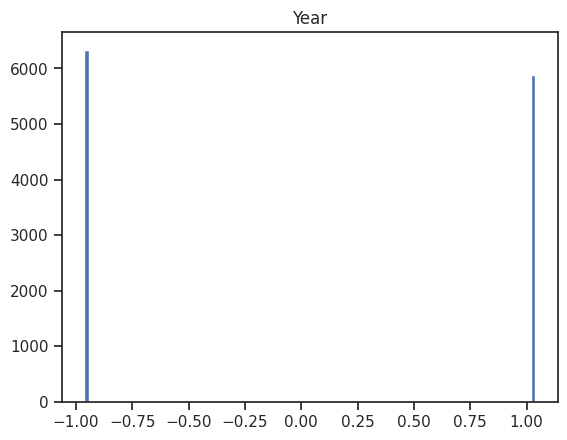

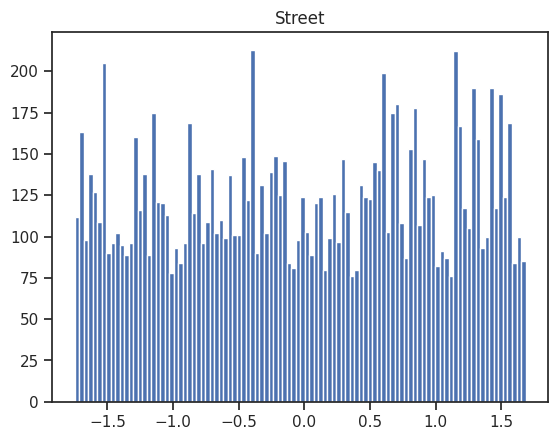

In [35]:
# После
for col in data.columns:
    plt.hist(sc2_data[col], 100)
    plt.title(col)
    plt.show()

## Обучение с фиксированным гиперапараметром

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_pinball_loss, d2_pinball_score, d2_absolute_error_score

In [37]:
data = sc2_data
target = sc2_data['Price']

data.drop(columns=['Price'], inplace=True)

In [38]:
data.shape

(12211, 22)

In [39]:
data.describe()

,Suburb,Rooms,Type,Method,SellerG,Distance,Postcode,Bedroom2,Bathroom,Car,...,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Day,Month,Year,Street
count,1.221100e+04,1.221100e+04,1.221100e+04,1.221100e+04,1.221100e+04,1.221100e+04,1.221100e+04,1.221100e+04,1.221100e+04,1.221100e+04,...,1.221100e+04,1.221100e+04,1.221100e+04,1.221100e+04,1.221100e+04,1.221100e+04,1.221100e+04,1.221100e+04,1.221100e+04,1.221100e+04
mean,-1.675836e-16,9.775709e-17,-5.586119e-17,-8.728311e-17,6.749894e-17,4.096487e-16,-1.955142e-16,1.582734e-16,-9.542954e-17,4.655099e-17,...,8.006771e-16,3.956834e-17,6.633168e-14,1.136496e-13,-2.793060e-17,-3.491325e-18,4.073212e-18,5.586119e-17,9.682607e-15,6.517139e-17
std,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,...,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00,1.000041e+00
min,-1.713779e+00,-1.974554e+00,-6.679092e-01,-1.256809e+00,-1.692307e+00,-1.772836e+00,-1.180357e+00,-2.958890e+00,-2.202661e+00,-1.655768e+00,...,-2.623103e+01,-1.501642e+00,-4.964142e+00,-5.677929e+00,-1.896366e+00,-1.648721e+00,-1.740993e+00,-1.995070e+00,-9.629336e-01,-1.749416e+00
25%,-9.609414e-01,-9.321296e-01,-6.679092e-01,-3.618941e-01,-7.344135e-01,-7.016215e-01,-6.766680e-01,-8.957937e-01,-7.510612e-01,-6.038672e-01,...,-2.283664e-01,-8.915352e-01,-6.186451e-01,-6.397538e-01,-8.985197e-01,-7.032906e-01,-8.886206e-01,-5.665816e-01,-9.629336e-01,-8.613720e-01
50%,5.387686e-03,1.102950e-01,-6.679092e-01,-3.618941e-01,5.926979e-02,-1.024677e-01,-2.302162e-01,1.357545e-01,-7.510612e-01,-6.038672e-01,...,1.119827e-01,1.253089e-01,9.109507e-02,5.494373e-02,5.982504e-01,-2.027685e-01,-3.624805e-02,-2.094594e-01,-9.629336e-01,1.282498e-02
75%,8.593529e-01,1.102950e-01,5.023935e-01,-3.618941e-01,8.119005e-01,5.148423e-01,5.024227e-01,1.357545e-01,7.005387e-01,4.480333e-01,...,2.821572e-01,8.370998e-01,6.820801e-01,6.175395e-01,5.982504e-01,6.586696e-01,9.378921e-01,5.047849e-01,1.038493e+00,8.547127e-01
max,1.735791e+00,7.407267e+00,1.672696e+00,2.322850e+00,1.756110e+00,6.833191e+00,1.000383e+01,1.767207e+01,9.410138e+00,8.863237e+00,...,1.745658e+00,1.752259e+00,4.677957e+00,5.393332e+00,1.596097e+00,3.249163e+00,1.668497e+00,1.933274e+00,1.038493e+00,1.684600e+00


In [40]:
target.describe()

count    1.221100e+04
mean    -1.629285e-16
std      1.000041e+00
min     -1.531994e+00
25%     -6.632256e-01
50%     -2.640617e-01
75%      4.012117e-01
max      1.242309e+01
Name: Price, dtype: float64

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.5, random_state=1)

In [42]:
K = 70

cl = KNeighborsRegressor(n_neighbors=K)
cl.fit(X_train, y_train)
target_train = cl.predict(X_train)
target_test = cl.predict(X_test)

In [43]:
def scorer(y_true, y_pred):
    scores = {
        'r2': r2_score, 
        'mean_squared_error': mean_squared_error, 
        'mean_absolute_error': mean_absolute_error, 
        'r2_score': r2_score, 
        'explained_variance_score': explained_variance_score, 
        'mean_pinball_loss': mean_pinball_loss, 
        'd2_pinball_score': d2_pinball_score, 
        'd2_absolute_error_score': d2_absolute_error_score
    }

    for score, score_func in scores.items():
        scores[score] = score_func(y_true, y_pred)
    return scores


In [44]:
print('Train: ', scorer(y_train, target_train))
print()
print('Test :', scorer(y_test, target_test))

Train:  {'r2': 0.6074478363288117, 'mean_squared_error': 0.4054128638342073, 'mean_absolute_error': 0.38465733025879834, 'r2_score': 0.6074478363288117, 'explained_variance_score': 0.6080485130705291, 'mean_pinball_loss': 0.19232866512939917, 'd2_pinball_score': 0.4454301531494722, 'd2_absolute_error_score': 0.4454301531494722}

Test : {'r2': 0.6358064659388151, 'mean_squared_error': 0.3521518459937633, 'mean_absolute_error': 0.3775204179759272, 'r2_score': 0.6358064659388151, 'explained_variance_score': 0.6359862432962011, 'mean_pinball_loss': 0.1887602089879636, 'd2_pinball_score': 0.4426146306868046, 'd2_absolute_error_score': 0.4426146306868046}


## Поиск лучших гиперпараметров

In [45]:
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Вспомогательные функции

In [46]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring='accuracy'):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(str(scoring))
    # plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.4,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt


In [47]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [48]:
def get_best_param_for_score(results, score):
    return results['params'][np.where(results[f"rank_test_{score}"] == 1)[0][0]]

def get_best_param_for_scores(results, scores):
    return {score: get_best_param_for_score(results, score) for score in scores}

In [68]:
def show_plots_for_scores(n_range, results, scores):
    for score in scores:
        plt.plot(n_range, results[f"mean_test_{score}"])
        plt.title(score)
        plt.show()

### Поиск

In [50]:
scores = [
        'r2', 
        'neg_mean_squared_error', 
        'neg_mean_absolute_error',  
]

#### RandomizedSearch + KFolds 

In [51]:
n_range_1 = np.array(range(3,100,10))
tuned_parameters_1 = [{'n_neighbors': n_range_1}]
tuned_parameters_1

[{'n_neighbors': array([ 3, 13, 23, 33, 43, 53, 63, 73, 83, 93])}]

In [52]:
data.shape

(12211, 22)

In [53]:
kf = KFold(n_splits=24) # 500 samples for 1 fold 

In [54]:
%%time
clf_rs = RandomizedSearchCV(KNeighborsRegressor(), tuned_parameters_1, cv=kf, scoring=scores , n_iter=n_range_1.size, refit=False)
s = clf_rs.fit(X_train, y_train)

CPU times: user 14.7 s, sys: 39.4 ms, total: 14.8 s
Wall time: 4.12 s


In [55]:
get_best_param_for_scores(clf_rs.cv_results_, scores)

{'r2': {'n_neighbors': 13},
 'neg_mean_squared_error': {'n_neighbors': 13},
 'neg_mean_absolute_error': {'n_neighbors': 13}}

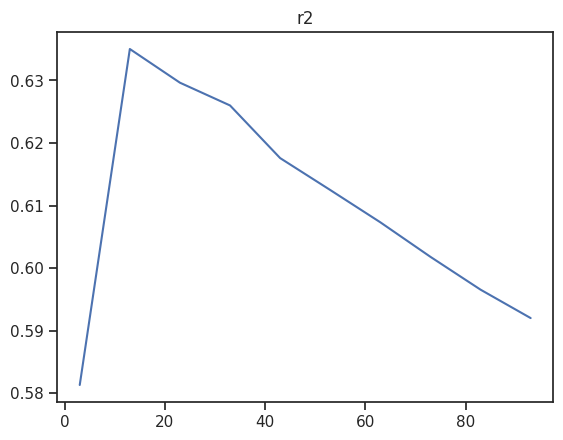

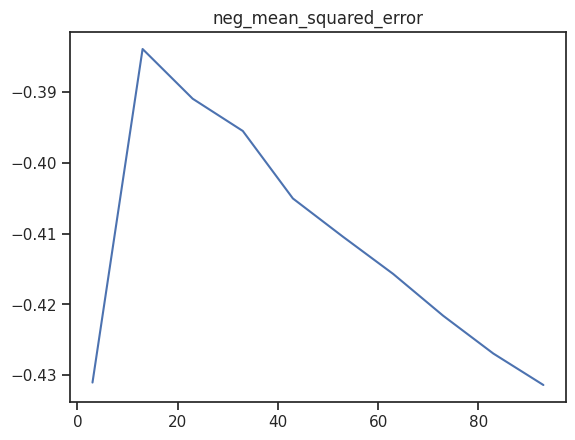

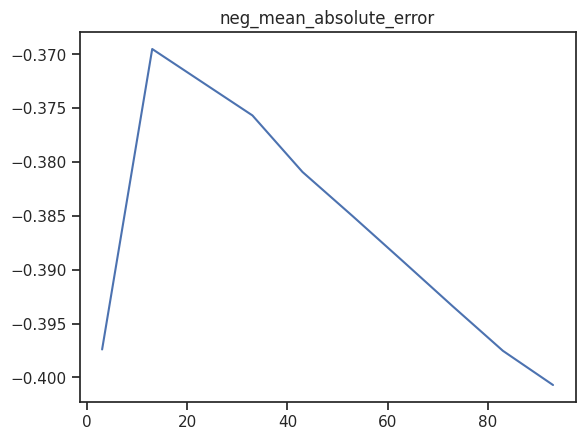

In [69]:
show_plots_for_scores(n_range_1, clf_rs.cv_results_, scores)

#### GridSearch + LeavePOut folds

In [57]:
n_range_2 = np.array(range(10,20,1))
tuned_parameters_2 = [{'n_neighbors': n_range_2}]
tuned_parameters_2

[{'n_neighbors': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])}]

In [58]:
data.shape[0] / 3

4070.3333333333335

In [62]:
rkf = RepeatedKFold(n_splits=12, n_repeats=2)
len(list(rkf.split(X_train, y_train)))

24

In [63]:
%%time
clf_gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters_2, cv=rkf, scoring=scores, refit=False)
clf_gs.fit(X_train, y_train)

CPU times: user 15.6 s, sys: 23.4 ms, total: 15.6 s
Wall time: 4.46 s


GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=12, random_state=None),
             estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])}],
             refit=False,
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_error'])

In [71]:
get_best_param_for_scores(clf_gs.cv_results_, scores)

{'r2': {'n_neighbors': 11},
 'neg_mean_squared_error': {'n_neighbors': 11},
 'neg_mean_absolute_error': {'n_neighbors': 14}}

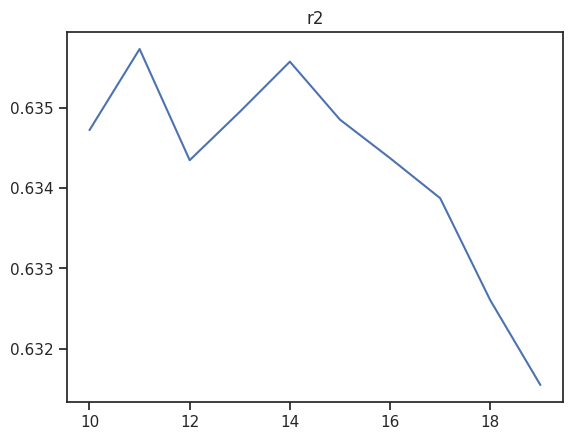

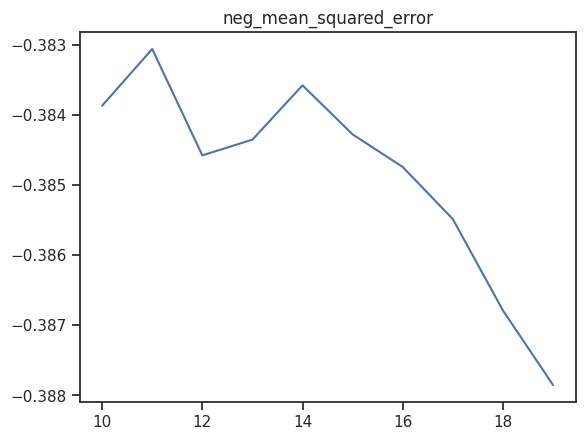

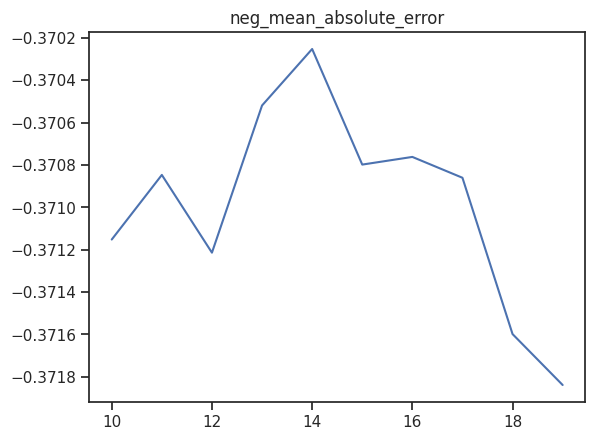

In [70]:
show_plots_for_scores(n_range_2, clf_gs.cv_results_, scores)

##### Validation curve

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

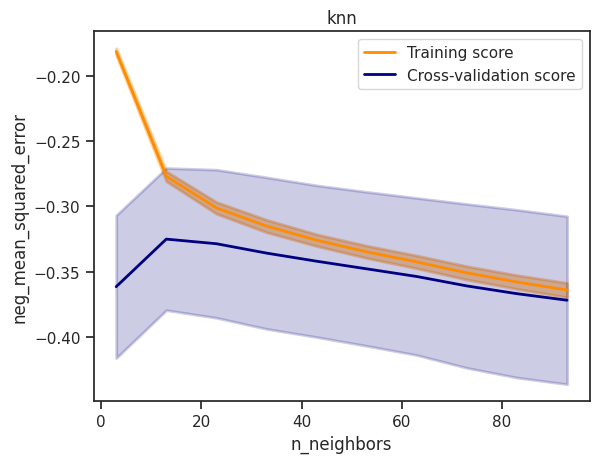

In [76]:
plot_validation_curve(KNeighborsRegressor(), 'knn', 
                      X_test, y_test, 
                      param_name='n_neighbors', param_range=n_range_1, 
                      cv=12, scoring='neg_mean_squared_error')

#### Learning Curve for best hyperparams

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

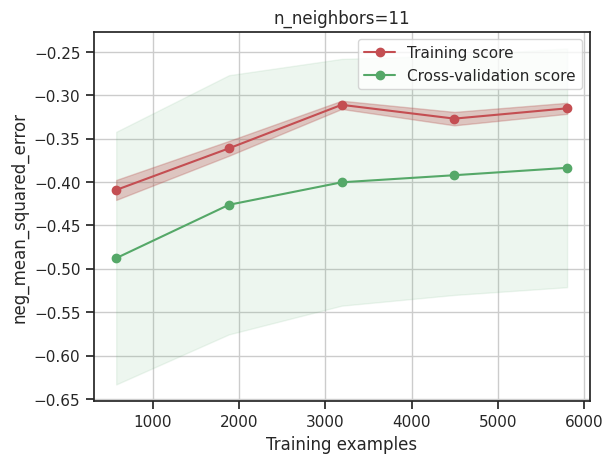

In [78]:
K = 11
plot_learning_curve(KNeighborsRegressor(n_neighbors=11), 'n_neighbors=11', 
                    X_train, y_train, cv=20, scoring='neg_mean_squared_error')

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.10/site-packages/matplotlib/pyplot.py'>

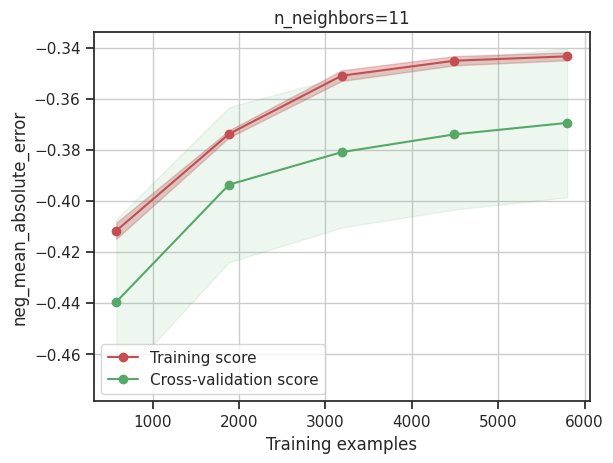

In [79]:
K = 14
plot_learning_curve(KNeighborsRegressor(n_neighbors=14), 'n_neighbors=11', 
                    X_train, y_train, cv=20, scoring='neg_mean_absolute_error')